# Background
Imagine a dataset with n training examples, $ \mathcal{D} = \{ (\mathbf{x_1}, y_1), (\mathbf{x_2}, y_2) ... (\mathbf{x_N}, y_N) \}$, where $\mathbf{x_n}$ is an input vector and $y$ is a binary variable (0 or 1)

**Logistic regression** assumes a probabilistic relationship between $\mathbf{x}$ and $y$. As the name suggests, the probability function is logistic:
\begin{align*}
P(y=1|\mathbf{x}, \beta) &= \sigma (\mathbf{\beta}^T \mathbf{x}) \\
P(y=0|\mathbf{x}, \beta) &= 1 - \sigma (\mathbf{\beta}^T \mathbf{x}) = \sigma (-\mathbf{\beta}^T \mathbf{x})
\end{align*}
where $\sigma (\mathbf{\beta}^T \mathbf{x})= \frac{1}{1 + \exp(-\mathbf{\beta}^T \mathbf{x})}$

Statistical theory explains that the parameters of the logistic model $\beta$ can be inferred by **maximizing the likelihood** of the parameters $\mathcal{L}(\beta)$ given the data $\mathcal{D}$

$$\mathcal{L}(\beta) = P(\mathcal{D}|\beta) = \prod_{n=1}^{N} P(y_n|\beta, \mathbf{x_n}) = \prod_{n=1}^{N} y_n\sigma (\mathbf{\beta}^T \mathbf{x}) + (1-y_n)  \sigma (-\mathbf{\beta}^T \mathbf{x})$$
$$ \log \mathcal{L}(\beta) = \sum_{n=1}^{N} y_n\log \left(\sigma (\mathbf{\beta}^T \mathbf{x}) \right) + (1-y_n) \log \left(\sigma (-\mathbf{\beta}^T \mathbf{x}) \right)$$
The maximum $\widehat{\beta} = \arg\!\max_{\beta} \mathcal{L}(\beta)$ can be found either by performing **gradient ascend** on $\mathcal{L}(\beta)$ or by **newton raphson** on $\frac{d}{d\mathbf{\beta}} \mathcal{L}(\beta) = 0$

# Task 1: Gradients of parameters in logistic regression
Answer:
$$\frac{d}{d\beta_i} \log\mathcal{L}(\beta) = \sum_{n=1}^{N} x^{(n)}_i \left[y^{(n)} - \sigma (\mathbf{\beta}^T \mathbf{x}^{(n)}) \right]$$
where $i$ indexes the component of the parameter vector $\mathbf{\beta}$

# Task 2: Gradient Ascend Pseudo-code
High level math:
$$ \mathbf{\beta}(t+1) = \mathbf{\beta}(t) + \eta \frac{d}{d\mathbf{\beta}} \mathcal{L}(\beta)$$
where $\eta$ is the learning rate.

Max-iteration pseudo code:
maxiter = 1000
for i in range(maxiter)

# Task 3: Visualise data

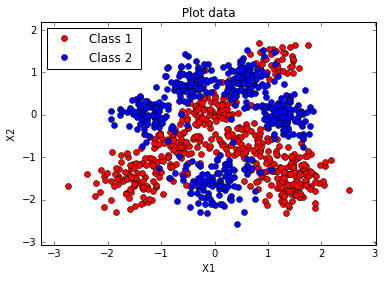

In [1]:
from appendix import *
X = np.loadtxt ('X.txt') # 1000 x 2
y = np.loadtxt ('y.txt') # 1000 x 1

plot_data(X, y)

Comments
- The two classes are not linearly separable. There is also no clear line which separates the red and blue regions. 
- But at least the blue and red regions are not significantly overlapping. Some nonlinear classifier can separate the two classes

# Task 4: Split Data
multiple ways to split data

In [2]:
test_ratio = 0.1
N = np.size(y)
indices = np.random.permutation(N)
idb  = int(test_ratio * N)
X_test = X[indices[:idb], : ]
y_test = y[indices[:idb]]

X_train = X[indices[idb:], : ]
y_train = y[indices[idb:]]

# Task 5: Training

In [24]:
def add_ones_column(X):
    if X.ndim ==2:
        N = np.shape(X)[0]
    elif X.ndim == 1:
        return np.insert(X,0,1)
    else:
        raise ValueError
    z = np.ones((N, 1))
    return np.append(z,X, axis=1)


def logistic(X, beta):
    X = add_ones_column(X)
    return 1./(1 + np.exp(- np.sum(X * beta, axis=1))) # make suitable for single row

def likelihood(X,y, beta):
    h = logistic(X,beta)
    
    prob_class1 = h * y
    prob_class2 = (1-h)* (np.logical_not(y))
    probs = prob_class1 + prob_class2
    return probs

def log_likelihood_score(X,y, beta):
    log_likes = np.log(likelihood(X,y,beta))
    mask = log_likes == -np.inf
    if np.any(mask):
        X = add_ones_column(X[mask,:])
        backup = np.sum(X * beta, axis=1)
        y = y[mask]
        backup[y==0] = - backup[y==0]
        log_likes[mask] = backup
    return np.average(log_likes) # average log-likelihood per datapoint

def log_likelihood(X,y, beta):
    return np.sum(np.log(likelihood(X,y,beta)))

def log_like_gradients(X,y, beta):
    factor = (y - logistic(X, beta))
    X = add_ones_column(X)
    grad = np.sum((X.T * factor).T , axis=0)
    N = np.shape(X)[0]
    return grad / N

def gradient_ascent0(grad_f, beta, train_score_f, test_score_f, length = 500, learning_rate = 0.1):
    # Initialise output variables
    train_score = np.zeros(length)
    test_score = np.zeros(length)
    # Iterations
    for i in range(length):
        beta = beta + learning_rate * grad_f(beta)
        train_score[i] = train_score_f(beta)
        test_score[i] = test_score_f(beta)
    return beta, train_score, test_score

def gradient_ascent(X,y, beta, length = 1000, learning_rate = 0.1):
    score = np.zeros(length)
    change = np.zeros(length)
    for i in range(length):
        grad = log_like_gradients(X, y, beta)
        beta = beta + learning_rate * grad
        score[i] = log_likelihood_score(X,y,beta)
        change[i] = np.linalg.norm(grad)
    return beta, score, change

def newton_raphson(X,y, beta, length = 10):
    X1 = add_ones_column(X)
    score = np.zeros(length)
    change = np.zeros(length)
    for i in range(length):
        top = logistic(X, beta) - y
        top = np.sum((X1.T * top).T, axis=0)

        bottom = logistic(X, beta) * logistic(X,-beta)
        bottom = np.sum(((X1*X1).T * bottom).T, axis=0)

        beta = beta - top / bottom
        score[i] = log_likelihood_score(X,y,beta)
        change[i] = np.linalg.norm(top / bottom)
    return beta, score, change

In [4]:
beta_train, scores_train, changes_train = newton_raphson(X_train,y_train, np.random.random(3))
beta_train

array([ 0.35037722, -0.10831908,  0.81404962])

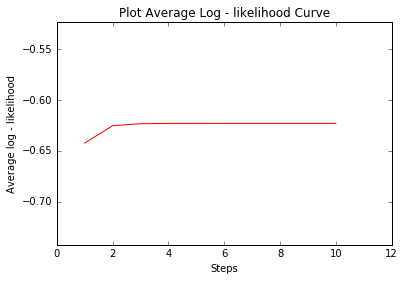

In [5]:
plot_ll(scores_train)

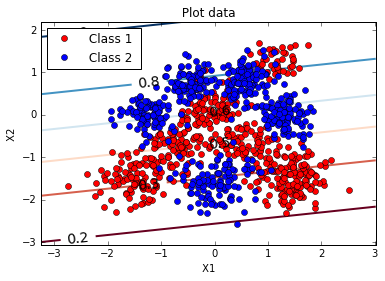

In [6]:
def predict(X):
    return logistic(X, beta_train)
plot_predictive_distribution(X, y, predict)

# Task 6: Results

## Log-likelihoods

In [7]:
import pandas as pd

# Compute log likelihood
score_test = log_likelihood_score(X_test,y_test, beta_train)
score_train = log_likelihood_score(X_train,y_train, beta_train)
s1 = pd.Series([score_train, score_test], index=['training score', 'test score'])

# Print
s1

training score   -0.622939
test score       -0.629314
dtype: float64

## Confusion matrix

In [8]:
y_predict = logistic(X_test, beta_train)

def confusion_matrix(predict, truth):
    true_negatives = np.sum(np.logical_and(np.logical_not(predict), np.logical_not(truth)))
    false_positives = np.sum(np.logical_and(predict, np.logical_not(truth)))
    false_negatives = np.sum(np.logical_and(np.logical_not(predict), truth))
    true_positives = np.sum(np.logical_and(predict, truth))
    d = {'predict = 0' : pd.Series([true_negatives, false_negatives], index=['y = 0', 'y = 1']), 
         'predict = 1' : pd.Series([false_positives, true_positives], index=['y = 0', 'y = 1'])}
    df = pd.DataFrame(d)
    return df

In [9]:
confusion_matrix(y_predict > 0.5, y_test)

predict = 0  predict = 1
y = 0           38           18
y = 1           10           34

# Task 7: Receiver Operator Characteristic

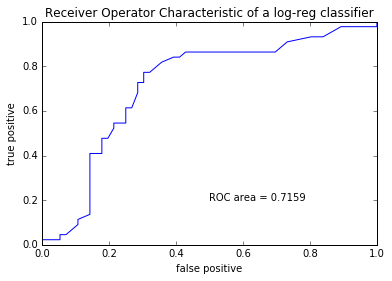

In [10]:
y_predict = logistic(X_test, beta_train)

def ROC(predict, truth, N=101):
    taus = np.linspace(0,1,N)
    false_pos_rate = np.zeros(N)
    true_pos_rate = np.zeros(N)

    for i in range(N):
        tau = taus[i]
        y_p = predict > tau
        false_pos_rate[i] = np.sum(np.logical_and(y_p, np.logical_not(truth))) / np.sum(np.logical_not(truth))
        true_pos_rate[i] = np.sum(np.logical_and(y_p, truth)) / np.sum(truth)
    return false_pos_rate, true_pos_rate

def plot_ROC(false_pos_rate, true_pos_rate):
    ax = plt.figure()
    plt.plot(false_pos_rate, true_pos_rate)
    plt.xlabel('false positive')
    plt.ylabel('true positive')
    plt.title('Receiver Operator Characteristic of a log-reg classifier')
    area = np.trapz(true_pos_rate[::-1], false_pos_rate[::-1])
    plt.text(0.5,0.2,'ROC area = ' + '{:01.4f}'.format(area))
    plt.show()

false_pos_rate, true_pos_rate = ROC(y_predict, y_test)    
plot_ROC(false_pos_rate, true_pos_rate)

## Comments
This classifier does not perform well.

# Task 8: Radial Basis Functions for logistic regression

In [28]:
# hyperparameters
ll = [0.01,0.1,1]
eta = [10,1,0.1]

# Initialise Storage Variables
rbfbeta_train = {}
rbfscore_train = {}
rbfscore_test = {}

rbfX_train = {}
rbfX_test = {}

# Transform input vector
for i in range(3):
    rbfX_train[i] =(expand_inputs(ll[i], X_train, X_train))
    rbfX_test[i]=(expand_inputs(ll[i], X_test, X_train))
    
# Train
for i in range(3):
#     beta, score, change = \
#         gradient_ascent(rbfX_train[i],y_train, np.random.random(len(y_train) + 1), length=1000, learning_rate = eta[i])
    grad_f = lambda beta : log_like_gradients(rbfX_train[i],y_train, beta)
    train_score_f = lambda beta : log_likelihood_score(rbfX_train[i],y_train, beta)
    test_score_f = lambda beta : log_likelihood_score(rbfX_test[i],y_test, beta)
    
    beta, train_score, test_score = \
        gradient_ascent0(grad_f, np.random.random(len(y_train) + 1), train_score_f, test_score_f, length=1000, learning_rate = eta[i])
        
    rbfbeta_train[i] = beta
    rbfscore_test[i] = test_score
    rbfscore_train[i] = train_score

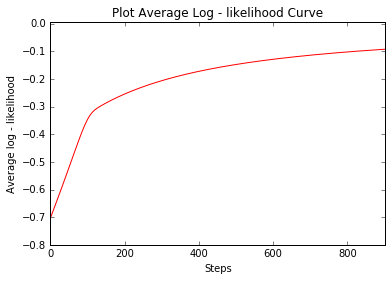

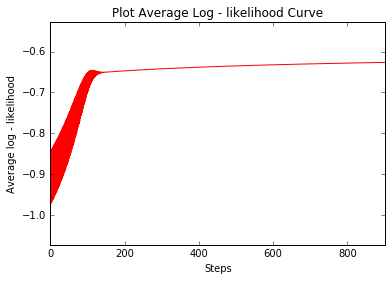

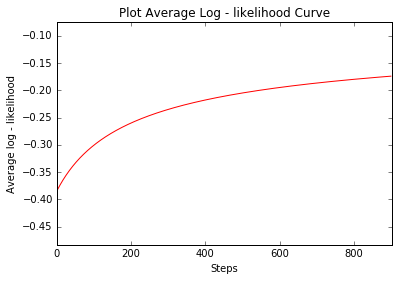

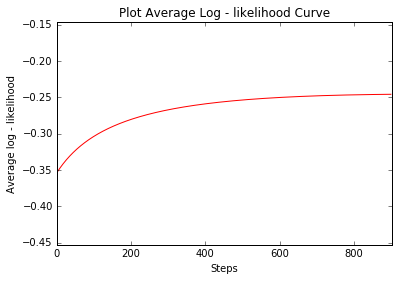

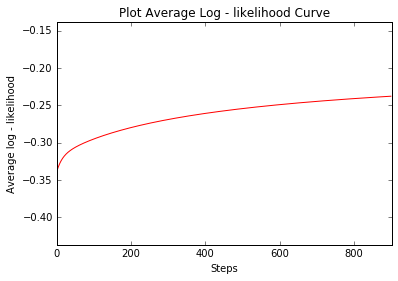

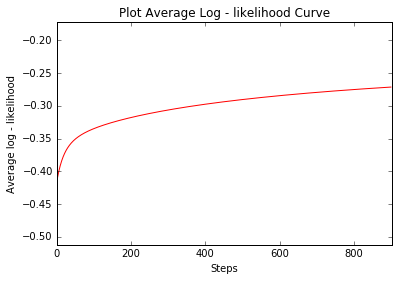

In [29]:
# Plot
for i in range(3):
    plot_ll(rbfscore_train[i][100:])
    plot_ll(rbfscore_test[i][100:])

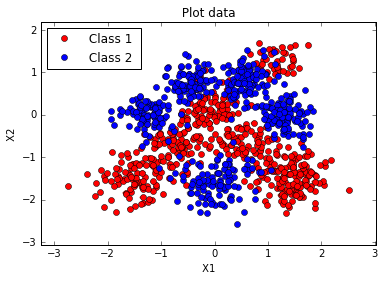

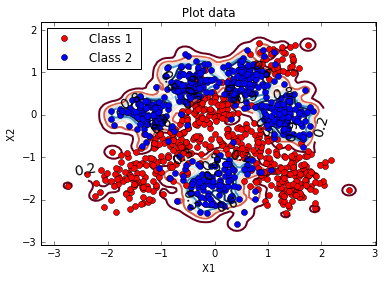

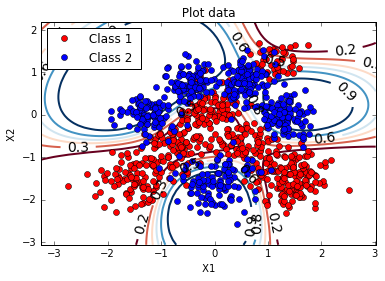

In [30]:
def predict_rbf0(X):
    rbfX = expand_inputs(ll[0], X, X_train)
    return logistic(rbfX, rbfbeta_train[0])
def predict_rbf1(X):
    rbfX = expand_inputs(ll[1], X, X_train)
    return logistic(rbfX, rbfbeta_train[1])
def predict_rbf2(X):
    rbfX = expand_inputs(ll[2], X, X_train)
    return logistic(rbfX, rbfbeta_train[2])

plot_predictive_distribution(X, y, predict_rbf0)
plot_predictive_distribution(X, y, predict_rbf1)
plot_predictive_distribution(X, y, predict_rbf2)

## Results

### Log likelihood

In [31]:
resultscores = {'simple' : s1} 
for i in range(3):
    # compute log - likelihood
    rbfscore_test = log_likelihood_score(rbfX_test[i],y_test, rbfbeta_train[i])
    rbfscore_train = log_likelihood_score(rbfX_train[i],y_train, rbfbeta_train[i])
    s = pd.Series([rbfscore_train, rbfscore_test], index=['training score', 'test score'])
    # save
    resultscores['RBF: l=' + str(ll[i])] =  s
    
# print
ff = pd.DataFrame(resultscores)
ff

RBF: l=0.01  RBF: l=0.1  RBF: l=1    simple
training score    -0.092012   -0.174191 -0.237594 -0.622939
test score        -0.626350   -0.245901 -0.271247 -0.629314

### Confusion Matrix

In [32]:
# Evaluate models on test set
rbfy_predicts = {}
for i in range(3):
    rbfy_predicts[i]=(logistic(rbfX_test[i], rbfbeta_train[i]))
    
# Print Confusion Matrix
for i in range(3):
    print('==Confusion matrix for l = ' + str(ll[i]) + '==')
    cm = confusion_matrix(rbfy_predicts[i]> 0.5, y_test)
    print(cm)
    print('\n')

==Confusion matrix for l = 0.01==
       predict = 0  predict = 1
y = 0           56            0
y = 1           37            7


==Confusion matrix for l = 0.1==
       predict = 0  predict = 1
y = 0           53            3
y = 1            7           37


==Confusion matrix for l = 1==
       predict = 0  predict = 1
y = 0           49            7
y = 1            3           41




### Receiver Operator Characteristics

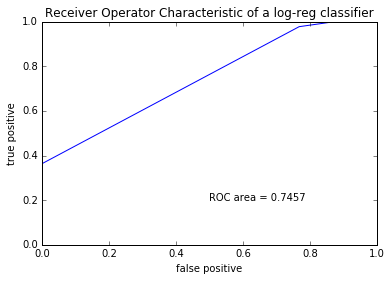

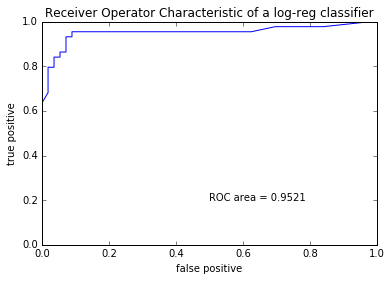

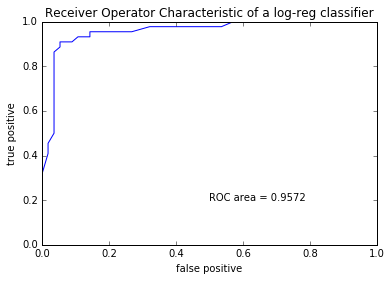

In [33]:
for i in range(3):
    rbffalse_pos_rate, rbftrue_pos_rate = ROC(rbfy_predicts[i], y_test)
    plot_ROC(rbffalse_pos_rate, rbftrue_pos_rate)

# Task 9: Adding Gaussian Priors

In [34]:
def log_post_gradients(X,y, beta, cov_inv):
    factor = (y - logistic(X, beta))
    X = add_ones_column(X)
    grad = np.sum((X.T * factor).T , axis=0) - np.dot(cov_inv,beta)
    N = np.shape(X)[0]
    return grad / N

def gradient_ascent2(X,y, beta, length = 500, learning_rate = 0.1, cov_inv=1):
    score = np.zeros(length)
    change = np.zeros(length)
    N = np.shape(X)[0]
    for i in range(length):
        grad = log_post_gradients(X, y, beta, cov_inv)
        beta = beta + learning_rate * grad
        score[i] = log_likelihood_score(X,y,beta)
        change[i] = np.linalg.norm(grad)
    return beta, score, change

In [35]:
# hyperparameters
ll = [0.01,0.1,1]
eta = [5,1,0.1]

# Initialise Storage Variables
maprbfbeta_train = {}
maprbfscore_train = {}
maprbfscore_test = {}

# Train

grad_f = lambda beta : log_post_gradients(X_train,y_train, beta, cov_inv = np.eye(len(beta)))
train_score_f = lambda beta : log_likelihood_score(X_train,y_train, beta)
test_score_f = lambda beta : log_likelihood_score(X_test,y_test, beta)

mapbeta_train, train_score, test_score = \
    gradient_ascent0(grad_f, np.random.random(3), train_score_f, test_score_f)

# mapbeta_train, score, change = gradient_ascent2(X_train,y_train, np.random.random(3), length=500)
for i in range(3):
    grad_f = lambda beta : log_post_gradients(rbfX_train[i],y_train, beta, cov_inv = np.eye(len(beta)))
    train_score_f = lambda beta : log_likelihood_score(rbfX_train[i],y_train, beta)
    test_score_f = lambda beta : log_likelihood_score(rbfX_test[i],y_test, beta)
    beta, train_score, test_score = \
    gradient_ascent0(grad_f, np.random.random(len(y_train) + 1), train_score_f, test_score_f)

#     beta, score, change = \
#         gradient_ascent2(rbfX_train[i],y_train, np.random.random(len(y_train) + 1), length=500, learning_rate = eta[i])
    
    maprbfbeta_train[i]=(beta)
    maprbfscore_train[i]=(train_score)
    maprbfscore_test[i]=(test_score)

In [ ]:
# Plot
for i in range(3):
    plot_ll(maprbfscore_train[i][100:])
    plot_ll(maprbfscore_test[i][100:])

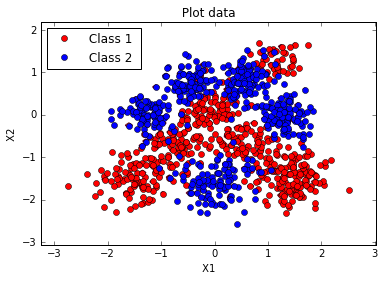

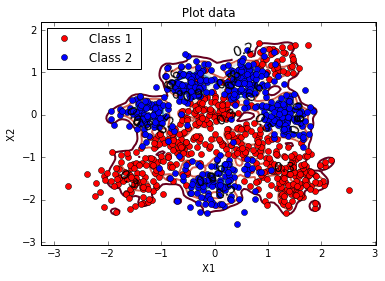

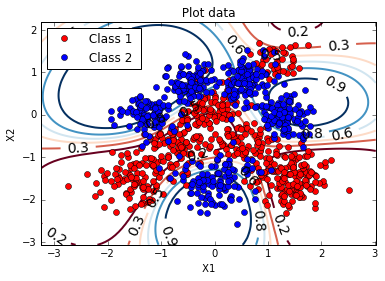

In [37]:
def predict_rbfmap0(X):
    rbfX = expand_inputs(ll[0], X, X_train)
    return logistic(rbfX, maprbfbeta_train[0])
def predict_rbfmap1(X):
    rbfX = expand_inputs(ll[1], X, X_train)
    return logistic(rbfX, maprbfbeta_train[1])
def predict_rbfmap2(X):
    rbfX = expand_inputs(ll[2], X, X_train)
    return logistic(rbfX, maprbfbeta_train[2])
plot_predictive_distribution(X, y, predict_rbfmap0)
plot_predictive_distribution(X, y, predict_rbfmap1)
plot_predictive_distribution(X, y, predict_rbfmap2)

## Training and Test scores for MAP

In [38]:
mapresultscores = {'simple' : s1} 

for i in range(3):
    # compute log - likelihood
    maprbfscore_test = log_likelihood_score(rbfX_test[i],y_test, maprbfbeta_train[i])
    maprbfscore_train = log_likelihood_score(rbfX_train[i],y_train, maprbfbeta_train[i])
    s = pd.Series([maprbfscore_train, maprbfscore_test], index=['training score', 'test score'])
    # save
    mapresultscores['RBF: l=' + str(ll[i])] =  s
    
# print
mapscores = pd.DataFrame(mapresultscores)
mapscores

RBF: l=0.01  RBF: l=0.1  RBF: l=1    simple
training score    -0.684275   -0.472714 -0.265787 -0.622939
test score        -0.686004   -0.428477 -0.297264 -0.629314

In [39]:
# Evaluate models on test set
maprbfy_predicts = {}
for i in range(3):
    maprbfy_predicts[i]=(logistic(rbfX_test[i], maprbfbeta_train[i]))
    
# Print Confusion Matrix
for i in range(3):
    print('==Confusion matrix for l = ' + str(ll[i]) + '==')
    cm = confusion_matrix(maprbfy_predicts[i]> 0.5, y_test)
    print(cm)
    print('\n')

==Confusion matrix for l = 0.01==
       predict = 0  predict = 1
y = 0           55            1
y = 1           44            0


==Confusion matrix for l = 0.1==
       predict = 0  predict = 1
y = 0           55            1
y = 1           13           31


==Confusion matrix for l = 1==
       predict = 0  predict = 1
y = 0           48            8
y = 1            2           42




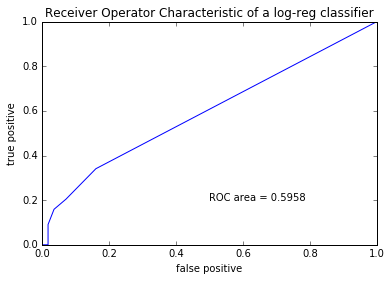

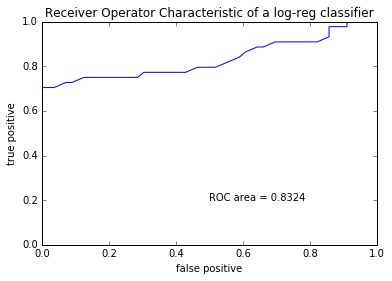

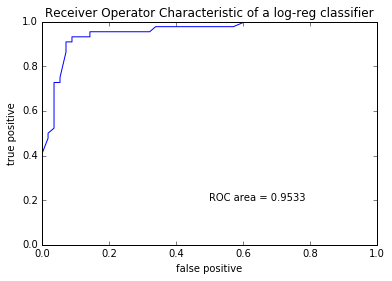

In [40]:
for i in range(3):
    maprbffalse_pos_rate, maprbftrue_pos_rate = ROC(maprbfy_predicts[i], y_test)
    plot_ROC(maprbffalse_pos_rate, maprbftrue_pos_rate)

# Task 10: Laplace approximation

# 10.1 Background

## What is laplace approximation?
**Short Answer**: Approximate a peak with a gaussian. Only information needed is location of the peak and curvature of peak
1. Transform function $f$  by taking logs. $g = \log f$
2. Taylor expand $g$ at its global minimum.
3. Truncate series at quadratic term to get $g_{approx}$
4. Transform $g_{approx}$ back to $f_{approx}$ by exponentiating. $f_{approx}$ will be gaussian
5. Fudge the normalizing constant

## Where is laplace approximation needed?
$$ 
\begin{align*}
\text{prior} \quad \color{green}{p(\mathbf{\omega})} &= \mathcal{N}\left(\mathbf{\omega}|\mathbf{0},\mathbf{I}\right) \\ 
\text{likelihood} \quad \color{blue}{p(\mathcal{D}|\mathbf{\omega})} &= \prod_{n=1}^{N} y_n\sigma (\mathbf{\omega}^T \mathbf{x}) + (1-y_n)  \sigma (-\mathbf{\omega}^T \mathbf{x}) \\
\text{posterior} \quad p(\mathbf{\omega}|\mathcal{D}) &= \frac{\color{blue}{p(\mathcal{D}|\mathbf{\omega})}\color{green}{p(\mathbf{\omega})}}{p(\mathcal{D})}\\ 
\text{predictive} \quad p(\mathbf{y^*}|\mathcal{D}, \mathbf{x^*}) &= \int \sigma (\mathbf{\omega}^T \mathbf{x^*}) \frac{\color{blue}{p(\mathcal{D}|\mathbf{\omega})}\color{green}{p(\mathbf{\omega})}}{p(\mathcal{D})} d\mathbf{\omega}\\
\text{model evidence} \quad p(\mathcal{D}) &= \int \color{blue}{p(\mathcal{D}|\mathbf{\omega})}\color{green}{p(\mathbf{\omega})} d\mathbf{\omega}\\ 
\end{align*}
$$

**Short Answer**:
On the posterior. For use within the predictive integral.

**Long Answer**:
Our goal is to compute the predictive. However in this case, the posterior, predictive, and model evidence cannot be computed because they involve high dimensional integrals. Fortunately the integrals become tractable if we approximate the some of the integrands with gaussians. Why? Because gaussians are convenient and the integrals can be evaluated using results about gaussian distributions. 

While the denominator of the posterior, which is also called the normalizing constant or model evidence, is not computable, the numerator is. Since the demoninator does not depend on $\omega$, the location of the maximum posterior $\omega_{map}$ can be found by optimization. The hessian of the log-posterior at $\omega_{map}$,$H_{map}$, can also be found analytically.

With only $H_{map}$ and $\omega_{map}$, we can laplace approximate the posterior into a gaussian, thus fudging away our need to know the normalizing constant.
$$ 
\begin{align*}
\log p(\mathbf{\omega}|\mathcal{D}) &\approx \log p(\omega_{map}|\mathcal{D}) + \frac{1}{2} (\omega - \omega_{map})^T H_{map} (\omega - \omega_{map}) \\ 
p(\mathbf{\omega}|\mathcal{D}) &\approx \frac{1}{\sqrt{\left|-2\pi H_{map}\right|}} \exp \left(\frac{1}{2} (\omega - \omega_{map})^T H_{map} (\omega - \omega_{map})\right)
\end{align*}
$$
where $H_{map}$ is the hessian matrix of the multivariate log-posterior function evaluated at $\omega_{map}$. Note that in this notation the hessian is the negative of the covariance of the gaussian.


## How to evaluate the predictive distribution?

Even though we have approximated the posterior with a gaussian, marginalising the logistic prediction against the a high dimensional gaussian is computationally intractable. The trick here is to approximate the logistic function with a gaussian CDF. It's not a bad idea since both are sigmoid-likes curves. 

$$\int \color{red}{\sigma} (\mathbf{\omega}^T \mathbf{x^*}) p(\mathbf{\omega}|\mathcal{D}) \approx \int \color{red}{\Phi} (\lambda\mathbf{\omega}^T \mathbf{x^*}) p(\mathbf{\omega}|\mathcal{D})$$

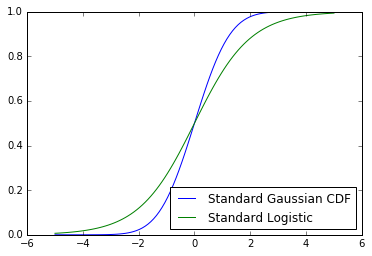

In [41]:
def demo_logistic_approx():
    from scipy.stats import norm
    import numpy as np
    import matplotlib.pyplot as plt
    x = np.linspace(-5,5,100)
    g = norm.cdf(x)
    l = 1 / (1 + np.exp(-x))
    plt.plot(x,g, label = "Standard Gaussian CDF")
    plt.plot(x,l, label = "Standard Logistic")
    plt.legend(loc = 4)
    plt.show()
    
demo_logistic_approx()

As seen in the plot, the gaussian cdf and the logistic function needs a bit of horizontal scaling to be approximately equivalent. This is be done by matching their gradients at $x = 0$

$$
\begin{align*}
\Phi(\lambda x) &\approx \sigma(x)\\
\frac{d}{dx}\biggr|_{x=0}\Phi(\lambda x) &= \frac{d}{dx}\biggr|_{x=0}\sigma(x) \\
\frac{\lambda}{\sqrt{2\pi}} &= \frac{1}{4}\\
\lambda^2 = \frac{\pi}{8}
\end{align*}
$$

Even with a gaussian CDF, the integral is non-trivial. It requires two tricks that will be explained here:

Assuming we have an integral
$$ \int \Phi \left(\frac{x-\mu_2}{\sigma_2} \right) \mathcal{N} \left(\frac{x-\mu_1}{\sigma_1} \right) dx$$
Now imagine a gaussian random variable $Y$ with mean $\mu_2$ and variance $\sigma_2^2$, and another gaussian random variable $X$ with mean $\mu_1$ and variance $\sigma_1^2$. The integral is the probability that $X>Y$
$$P(X>Y) = \int P(Y<x)P(X=x)dx$$
But $P(X>Y)$ is equivalent to $P(0>Y-X)$. The sum of two gaussian variables is also a gaussian variable. 

$$
\begin{align*}
Z &= Y-X\\
\mathbb{E}(Z) &= \mu_2 - \mu_1\\
Var(Z) &= \sigma^2_2 + \sigma^2_1
\end{align*}$$
Therefore 
$$ \int \Phi \left(\frac{x-\mu_1}{\sigma_1} \right) \mathcal{N} \left(\frac{x-\mu_2}{\sigma_2} \right) dx = \Phi \left(\frac{0 -\mu_2 + \mu_1}{\sqrt{\sigma^2_2 + \sigma^2_1}} \right)$$

Putting it all together:

$$ 
\begin{align*}
p(\mathbf{y^*}|\mathcal{D}, \mathbf{x^*}) &= \int \sigma (\mathbf{\omega}^T \mathbf{x^*})p(\mathbf{\omega}|\mathcal{D})d\mathbf{\omega}\\
\end{align*}
$$

## Maximum Likelihood Estimation using Scipy's optimizer

### MLE of simple logistic regression

In [42]:
import scipy.optimize as spopt
def MLE(X,y,guess):
    grad = lambda beta : -log_like_gradients(X,y, beta)
    cost = lambda beta : -log_likelihood_score(X,y, beta)
    n = np.shape(X)[1]
    return spopt.fmin_l_bfgs_b(cost, guess, fprime=grad)

def MLE2(X,y, guess):
    cost = lambda beta : -log_likelihood_score(X,y, beta)
    n = np.shape(X)[1]
    return spopt.fmin_l_bfgs_b(cost, guess,  approx_grad=1)

In [43]:
beta_opt, f, d = MLE(X_train,y_train, np.random.random(3))
print ('Scipy Optimizer found:')
print (beta_opt)
print ('Your Gradient Ascent found:')
print (beta_train)

Scipy Optimizer found:
[ 0.35036911 -0.10834942  0.81417026]
Your Gradient Ascent found:
[ 0.35037722 -0.10831908  0.81404962]


### MLE of logistic regression with radial basis functions

In [44]:
rbfbeta_opt = {}
for i in range(3):
    x, f, d = MLE(rbfX_train[i],y_train, rbfbeta_train[i])
    rbfbeta_opt[i]=(x)
    print(d['warnflag'])
    
def opt_scores():
    print('Maximum Log-likelihood scores')
    df = {}
    for i in range(3):
        BFGS = log_likelihood_score(rbfX_train[i],y_train, rbfbeta_opt[i])
        GD = log_likelihood_score(rbfX_train[i],y_train, rbfbeta_train[i])
        s1 = pd.Series([BFGS, GD], index=['L-BFGS-B', 'Your Gradient Ascent'])
        df['l=' + str(ll[i])] = s1
    return pd.DataFrame(df)
        
df = opt_scores()
df

0
0
0
Maximum Log-likelihood scores


l=0.01     l=0.1       l=1
L-BFGS-B             -0.000130 -0.001376 -0.173279
Your Gradient Ascent -0.092012 -0.174191 -0.237594

### Difference between weights found by gradient descent and scipy

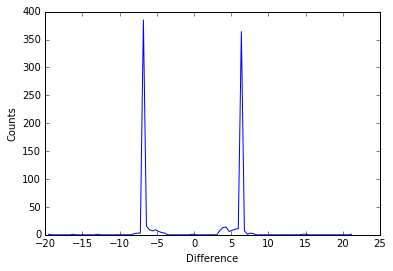

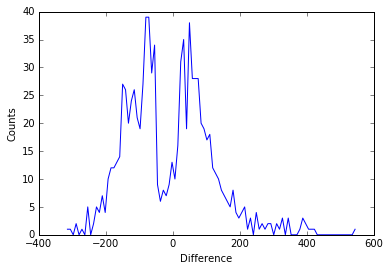

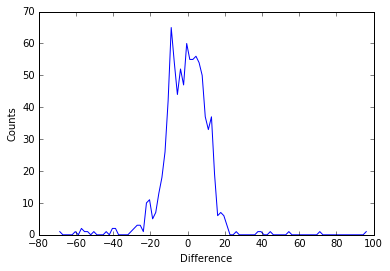

In [45]:
for i in range(3):
    hist, bins_e = np.histogram(rbfbeta_opt[i]-rbfbeta_train[i], 100)
    plt.plot(bins_e[:-1], hist)
    plt.xlabel('Difference')
    plt.ylabel('Counts')
    plt.show()

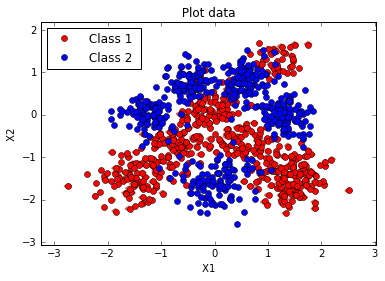

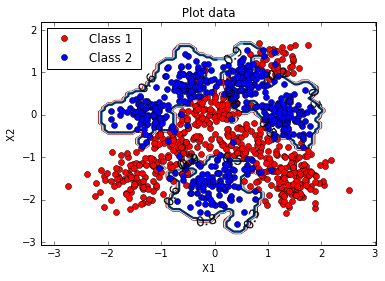

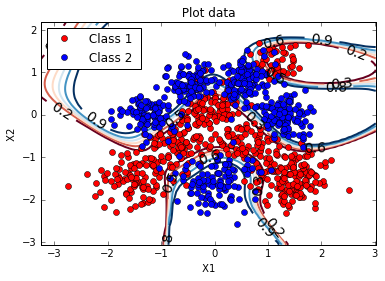

In [46]:
def predict_rbf_opt0(X):
    rbfX = expand_inputs(ll[0], X, X_train)
    return logistic(rbfX, rbfbeta_opt[0])
def predict_rbf_opt1(X):
    rbfX = expand_inputs(ll[1], X, X_train)
    return logistic(rbfX, rbfbeta_opt[1])
def predict_rbf_opt2(X):
    rbfX = expand_inputs(ll[2], X, X_train)
    return logistic(rbfX, rbfbeta_opt[2])

plot_predictive_distribution(X, y, predict_rbf_opt0)
plot_predictive_distribution(X, y, predict_rbf_opt1)
plot_predictive_distribution(X, y, predict_rbf_opt2)

### Comparing to SKLEARN's logistic regression

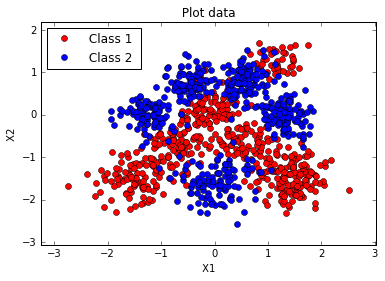

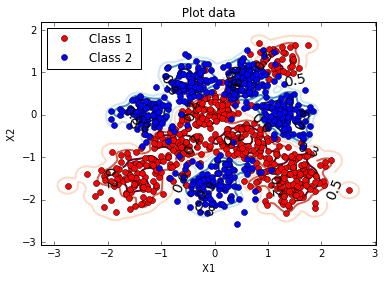

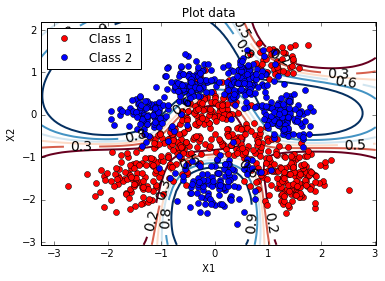

In [47]:
from sklearn.linear_model import LogisticRegression
SKLR = {}
for i in range(3):
    SKLR[i]=(LogisticRegression())
    SKLR[i].fit(add_ones_column(rbfX_train[i]), y_train)
    
def predict_rbfsk0(X):
    rbfX = expand_inputs(ll[0], X, X_train)
    return logistic(rbfX, SKLR[0].coef_)
def predict_rbfsk1(X):
    rbfX = expand_inputs(ll[1], X, X_train)
    return logistic(rbfX, SKLR[1].coef_)
def predict_rbfsk2(X):
    rbfX = expand_inputs(ll[2], X, X_train)
    return logistic(rbfX, SKLR[2].coef_)

plot_predictive_distribution(X, y, predict_rbfsk0)
plot_predictive_distribution(X, y, predict_rbfsk1)
plot_predictive_distribution(X, y, predict_rbfsk2)

## Maximum a Posteriori (MAP) estimation of $\beta$

In [48]:
# The optimizer will maximize the log-posterior
def log_posterior_score(X,y, beta, cov_inv):
    return log_likelihood_score(X,y, beta) - 0.5 * np.dot(beta,np.dot(cov_inv,beta)) / X.shape[0] # average log-likelihood per datapoint

def MAP(X,y, guess, cov_inv=1):
    N = X.shape[0]
    grad = lambda beta : -log_post_gradients(X,y, beta, cov_inv)
    cost = lambda beta : -log_posterior_score(X,y, beta, cov_inv)
    return spopt.fmin_l_bfgs_b(cost, guess, fprime=grad)

In [49]:
mapbeta_opt, f, d = MAP(X_train,y_train, mapbeta_train)

In [50]:
maprbfbeta_opt = {}
maprbfFMIN_opt = {}
for i in range(3):
    x, f, d = MAP(rbfX_train[i],y_train, maprbfbeta_train[i])
    maprbfbeta_opt[i] = x
    maprbfFMIN_opt[i] = f
    print(d['warnflag'])

0
0
0


In [51]:
def map_opt_scores():
    print('Maximum Log-posterior scores')
    df = {}
    for i in range(3):
        BFGS = log_posterior_score(rbfX_train[i],y_train, maprbfbeta_opt[i],1)
        GD = log_posterior_score(rbfX_train[i],y_train, maprbfbeta_train[i], 1)
        s1 = pd.Series([BFGS, GD], index=['L-BFGS-B', 'Your Gradient Ascent'])
        df['l=' + str(ll[i])] = s1
    return pd.DataFrame(df)
        
df = map_opt_scores()
df

Maximum Log-posterior scores


l=0.01     l=0.1       l=1
L-BFGS-B             -0.586489 -0.290408 -0.232368
Your Gradient Ascent -0.829982 -0.612590 -0.310850

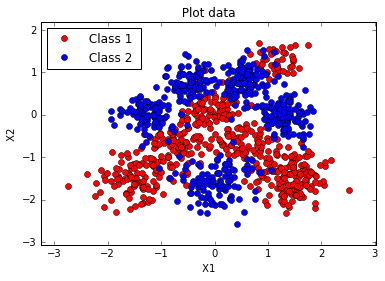

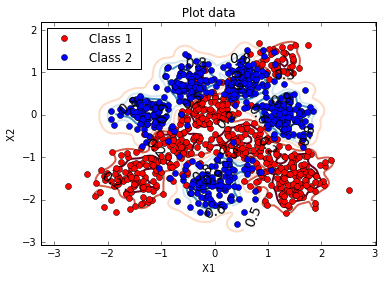

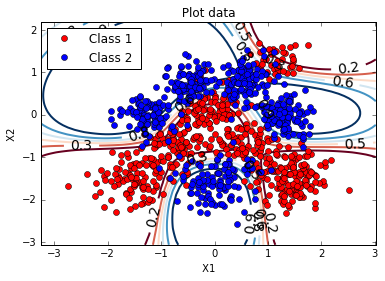

In [52]:
def predict_rbf_optmap0(X):
    rbfX = expand_inputs(ll[0], X, X_train)
    return logistic(rbfX, maprbfbeta_opt[0])
def predict_rbf_optmap1(X):
    rbfX = expand_inputs(ll[1], X, X_train)
    return logistic(rbfX, maprbfbeta_opt[1])
def predict_rbf_optmap2(X):
    rbfX = expand_inputs(ll[2], X, X_train)
    return logistic(rbfX, maprbfbeta_opt[2])

plot_predictive_distribution(X, y, predict_rbf_optmap0)
plot_predictive_distribution(X, y, predict_rbf_optmap1)
plot_predictive_distribution(X, y, predict_rbf_optmap2)

## Functions for approximating

In [53]:
def loglike_hessian(X, y, beta_mle):
    factor = - logistic(X,beta_mle) * logistic(X, -beta_mle)
    X = add_ones_column(X)
    out = np.einsum('i,ij,ik->jk',factor,X,X)
    return out

def logpost_hessian(X, y, beta_map, H_prior = None):
    H_mle = loglike_hessian(X, y, beta_map)
    if H_prior is None:
        H_prior = -np.eye(H_mle.shape[0])
    return H_prior + H_mle

def predictive_approx(X, betamap, Hmap_inv):
    n = X.shape[0]
    X = add_ones_column(X)
    top = np.dot(betamap, X.T)
    bot = -np.dot(Hmap_inv, X.T).T
    bot = np.sqrt(1+ np.sum(X*bot, axis=1) * np.pi/8 )
    z = top/bot
    return 1./(1 + np.exp(-z))

In [54]:
Hmap = {}
Hmap_inv = {}
from scipy import linalg
for i in range(3):
    Hmap[i] = (logpost_hessian(rbfX_train[i], y_train, maprbfbeta_opt[i]))
    Hmap_inv[i] = (linalg.inv(Hmap[i]))

In [55]:
Hmap['simple'] = logpost_hessian(X_train, y_train, mapbeta_opt)
print (Hmap['simple'])

[[-196.08919635  -17.28505677   80.82996959]
 [ -17.28505677 -212.08753496   -3.30235045]
 [  80.82996959   -3.30235045 -200.52493411]]


# Task 11: Predictive Distribution Results

## Predictive Function

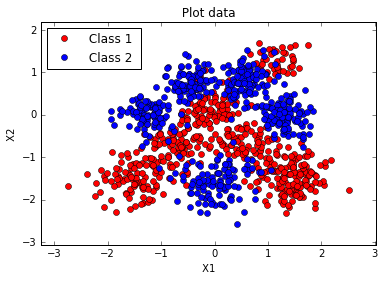

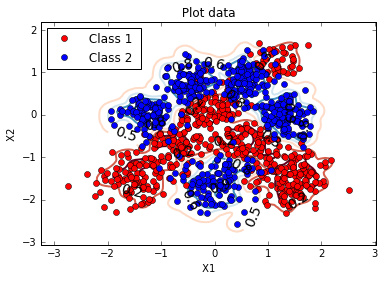

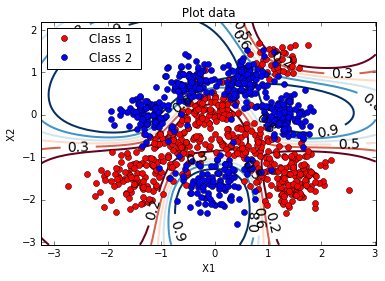

In [56]:
def predict_rbfpre0(X):
    rbfX = expand_inputs(ll[0], X, X_train)
    Hmap = logpost_hessian(rbfX, y_train, maprbfbeta_opt[0])
    return predictive_approx(rbfX, maprbfbeta_opt[0],Hmap_inv[0])
def predict_rbfpre1(X):
    rbfX = expand_inputs(ll[1], X, X_train)
    Hmap = logpost_hessian(rbfX, y_train, maprbfbeta_opt[1])
    return predictive_approx(rbfX, maprbfbeta_opt[1],Hmap_inv[1])
def predict_rbfpre2(X):
    rbfX = expand_inputs(ll[2], X, X_train)
    Hmap = logpost_hessian(rbfX, y_train, maprbfbeta_opt[2])
    return predictive_approx(rbfX, maprbfbeta_opt[2],Hmap_inv[2])

plot_predictive_distribution(X, y, predict_rbfpre0)
plot_predictive_distribution(X, y, predict_rbfpre1)
plot_predictive_distribution(X, y, predict_rbfpre2)  
    

## Confusion matrix

In [57]:
# Evaluate models on test set
laplacerbfy_predicts = {}
for i in range(3):
    laplacerbfy_predicts[i]=predictive_approx(rbfX_test[i], maprbfbeta_opt[i],Hmap_inv[i])
    
# Print Confusion Matrix
for i in range(3):
    print('==Confusion matrix for l = ' + str(ll[i]) + '==')
    cm = confusion_matrix(laplacerbfy_predicts[i]> 0.5, y_test)
    print(cm)
    print('\n')

==Confusion matrix for l = 0.01==
       predict = 0  predict = 1
y = 0           56            0
y = 1           30           14


==Confusion matrix for l = 0.1==
       predict = 0  predict = 1
y = 0           51            5
y = 1            3           41


==Confusion matrix for l = 1==
       predict = 0  predict = 1
y = 0           53            3
y = 1            4           40




## Training and Test Scores

In [58]:
for i in range(3):
    # compute log - likelihood
    maprbfscore_test = log_likelihood_score(rbfX_test[i],y_test, maprbfbeta_opt[i])
    maprbfscore_train = log_likelihood_score(rbfX_train[i],y_train, maprbfbeta_opt[i])
    s = pd.Series([maprbfscore_train, maprbfscore_test], index=['training score', 'test score'])
    # save
    mapresultscores['RBF: l=' + str(ll[i])] =  s
    
# print
mapscores = pd.DataFrame(mapresultscores)
mapscores

RBF: l=0.01  RBF: l=0.1  RBF: l=1    simple
training score    -0.502899   -0.211587 -0.208883 -0.622939
test score        -0.678006   -0.266438 -0.234741 -0.629314

# Task 12: Model Evidence

## Model Evidence of Existing Models

In [59]:
def log_prior(beta, cov_inv=None):
    if cov_inv is None:
        out = -0.5 * np.dot(beta,beta)
        out2 = - np.log(2*np.pi) * (np.size(beta)/2)
    else:
        out = -0.5 * np.dot(beta, np.dot(cov_inv,beta)) 
        sign , logdet = np.linalg.slogdet(cov_inv/(2*np.pi))
        out2 = sign * logdet * 0.5
    return out + out2

def log_model_evidence2(H_map, beta_map, X, y, cov_inv=None):
    prior = log_prior(beta_map, cov_inv)
    like = log_likelihood(X, y, beta_map)
    sign, logdet = np.linalg.slogdet(-H_map/(2*np.pi))
    inte = sign * logdet * -0.5
    return prior + like + inte

def log_model_evidence(H_map, beta_map, X, y):
    prior = log_prior(beta_map)
    like = log_likelihood(X, y, beta_map)
    sign, logdet = np.linalg.slogdet(-H_map/(2*np.pi))
    inte = sign * logdet * -0.5
    return prior + like + inte

In [60]:
existing_model_evidence = {}

for i in range(3):
    existing_model_evidence['l=' + str(ll[i])]=(log_model_evidence(Hmap[i], maprbfbeta_opt[i], rbfX_train[i],y_train))
    
existing_model_evidence['simple']=log_model_evidence(Hmap['simple'], mapbeta_opt, X_train, y_train)

In [61]:
pd.Series(existing_model_evidence)

l=0.01   -627.799139
l=0.1    -348.046611
l=1      -235.698635
simple   -568.912894
dtype: float64

## Grid Search

In [62]:
# memoization variables
search_model_evidence = {}
search_training_score = {}
search_beta_map = {}
search_rbfX = {}
search_H_map = {}

In [63]:
# def add_existing_model():
#     for i in range(3):
#         search_model_evidence[(ll[i], 1)] = existing_model_evidence['l=' + str(ll[i])]
#         search_training_score[(ll[i], 1)] = log_likelihood_score(rbfX_train[i],y_train, maprbfbeta_opt[i])
# add_existing_model()

In [64]:
def grid_search(prior_sigma, lll):
    for l in lll:
        for sigma in prior_sigma:
            key = (l, sigma)
            
            # Calculate inverse covariance
            p = X_train.shape[0]+1
            cov_inv = np.eye(p)/sigma**2

            # Expand Inputs
            if key not in search_rbfX:
                x = expand_inputs(l, X_train, X_train)
                search_rbfX[key] = x
                xx = expand_inputs(l, X_test, X_train)
                

            # Find MAP solution
            if key not in search_beta_map:
                grad_f = lambda beta : log_post_gradients(x,y_train, beta, cov_inv = cov_inv)
                train_score_f = lambda beta : log_likelihood_score(x,y_train, beta)
                test_score_f = lambda beta : log_likelihood_score(xx,y_test, beta)
                beta, train_score, test_score = \
                    gradient_ascent0(grad_f, np.random.random(len(y_train) + 1), train_score_f, test_score_f, length=500)

#                 beta, score, change = \
#                 gradient_ascent2(x,y_train, np.random.random(len(y_train) + 1), length=500, learning_rate = 0.01, cov_inv=cov_inv)
                b, f, d =  MAP(search_rbfX[key], y_train, beta, cov_inv)
                search_beta_map[(l, sigma)] = b
                if d['warnflag'] != 0:
                    import warnings
                    warnings.warn('Did not converge')

            # Log Training Performance
            search_training_score[key] = log_likelihood_score(x,y_train, b)
            
            # Find Hessians
            if key not in search_H_map:
                h = logpost_hessian(x, y_train, b, H_prior = -cov_inv)
                search_H_map[key] = h

            # Output
            search_model_evidence[key] = (log_model_evidence2(h, b, x, y_train, cov_inv))

In [65]:
def GS_table(myDict):
    s = pd.Series(myDict, index=pd.MultiIndex.from_tuples(myDict,names=('l', 'sigma')))
    df = s.unstack()
    return df.fillna(0)

In [66]:
prior_sigma = [0.5,1,2]
lll = [0.1, 0.3, 0.9]
grid_search(prior_sigma, lll)

In [ ]:
print(GS_table(search_model_evidence))
print(GS_table(search_training_score))

sigma         0.5         1.0         2.0
l                                        
0.1   -417.964765 -348.050247 -321.956205
0.3   -227.491132 -220.760979 -229.309369
0.9   -248.184240 -223.640047 -218.134999
sigma       0.5       1.0       2.0
l                                  
0.1   -0.317360 -0.211587 -0.144604
0.3   -0.185063 -0.166467 -0.151188
0.9   -0.217154 -0.200441 -0.193312


In [ ]:
prior_sigma = [0.5,1,2]
lll = [0.5, 0.6, 0.7]
grid_search(prior_sigma, lll)